### Linear Regression

Implementation of Linear Regression Using Pytorch


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
import torch.nn.functional as F

In [2]:
df = pd.read_csv('/content/linreg-data.csv', index_col=0)
df.head()

,x1,x2,y
0,-2.201441,-0.468864,-30.355617
1,-0.291041,0.777277,25.560334
2,-0.327755,0.040071,32.797526
3,-0.075650,1.821915,72.734577
4,-0.862493,-0.467493,-48.072356


In [3]:
X = torch.tensor(df[['x1', 'x2']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.float)

In [4]:
torch.manual_seed(23)

shuffle_idx=torch.randperm(X.shape[0],dtype=torch.long)

X=X[shuffle_idx]
y=y[shuffle_idx]

In [5]:
percent70=int(X.shape[0]*0.7)

X_train=X[:percent70]
y_train=y[:percent70]

X_test=X[percent70:]
y_test=y[percent70:]

In [6]:
mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

## 1. Linear Regression Semi Automated

In [7]:
class LinearRegression():
  """
    Implementation of Linear Regression using minibatch gradient descent in PyTorch.
  """
  def __init__(self,num_features):
    self.num_features = num_features
    self.weights = torch.zeros(num_features,1, dtype=torch.float,requires_grad=True)
    self.bias = torch.zeros(1, dtype=torch.float,requires_grad=True)

  def forward(self,X):
    """
        This method computes the net input and reshapes the output from a 2D tensor to a 1D tensor.

    """
    return (torch.matmul(X,self.weights)+self.bias).reshape(-1)

  def train(self,X,y,epochs,lr=0.01,minibatch_size=10):
    """
        Trains the model using minibatch gradient descent.

        Before each epoch, the dataset is shuffled to prevent cycles during training.
    """
    torch.manual_seed(120)
    loss=[]
    for epoch in range(epochs):
      shuffle_idx=torch.randperm(X.shape[0],dtype=torch.long)
      minibatch_indices=torch.split(shuffle_idx,minibatch_size)
      for minibatch_idx in minibatch_indices:
        y_pred=self.forward(X[minibatch_idx])
        mse=torch.mean((y[minibatch_idx]-y_pred)**2,axis=0)
        grad_w=grad(mse,self.weights,retain_graph=True)[0]  # We took the 0th index as torch.autograd.grad returns a tuple of tensors,right now the tuple contains only one element but if we took the gradient wrt multiple tensors then we would have multiple elements in the tuple.Also we did retain_graph=TRue bcoz we still have to compute the gradient wrt bias
        grad_b=grad(mse,self.bias)[0]
        self.weights=self.weights-(lr*grad_w)
        self.bias=self.bias-(lr*grad_b)

      with torch.no_grad():
        # While defining the weights and biases we had written requires_grad=True ,so whenever they would be used computation graph would be automatically created
        # We used torch.no_grad() here because we dont want to unnecessarily create computation graph
        preds=self.forward(X)
        curr_loss=torch.mean((y-preds)**2)
        print(f'Epoch: {epoch+1}, Loss: {curr_loss}')
        loss.append(curr_loss)
    return loss



In [8]:
linear_regr=LinearRegression(num_features=2)

In [9]:
loss=linear_regr.train(X_test,y_test,100,lr=0.01)

Epoch: 1, Loss: 788.69140625
Epoch: 2, Loss: 479.338134765625
Epoch: 3, Loss: 398.831787109375
Epoch: 4, Loss: 377.5241394042969
Epoch: 5, Loss: 370.6434326171875
Epoch: 6, Loss: 369.29364013671875
Epoch: 7, Loss: 368.84063720703125
Epoch: 8, Loss: 368.66448974609375
Epoch: 9, Loss: 368.64801025390625
Epoch: 10, Loss: 368.6163024902344
Epoch: 11, Loss: 368.6653137207031
Epoch: 12, Loss: 368.66766357421875
Epoch: 13, Loss: 368.61370849609375
Epoch: 14, Loss: 368.63067626953125
Epoch: 15, Loss: 368.6920166015625
Epoch: 16, Loss: 368.61639404296875
Epoch: 17, Loss: 368.65899658203125
Epoch: 18, Loss: 368.691650390625
Epoch: 19, Loss: 368.6304016113281
Epoch: 20, Loss: 368.6392517089844
Epoch: 21, Loss: 368.6204833984375
Epoch: 22, Loss: 368.6383361816406
Epoch: 23, Loss: 368.6202697753906
Epoch: 24, Loss: 368.619140625
Epoch: 25, Loss: 368.6700439453125
Epoch: 26, Loss: 368.6311950683594
Epoch: 27, Loss: 368.6159973144531
Epoch: 28, Loss: 368.63031005859375
Epoch: 29, Loss: 368.6402282714

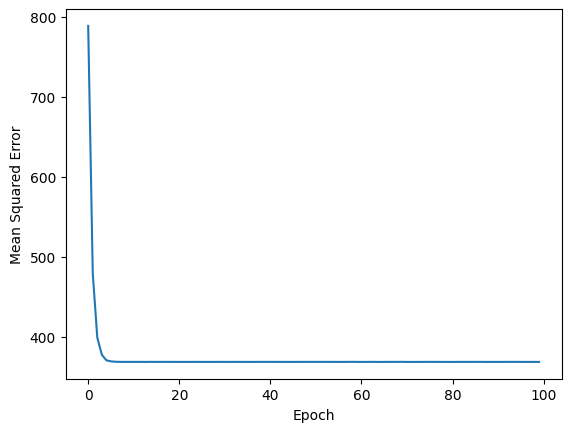

In [10]:
plt.plot(range(len(loss)), loss)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

## 2. Linear Regression Automated

In [11]:
class LinearRegression02(torch.nn.Module):
  """
    Implementation of Linear Regression using minibatch gradient descent in PyTorch.
  """
  def __init__(self,num_features):
    super(LinearRegression02, self).__init__()
    self.linear = torch.nn.Linear(num_features, 1)

    # changed random weights to zero to maintain uniformity with the previous implementation
    # (don't do this for multi-layer nets!)
    self.linear.weight.detach().zero_()
    self.linear.bias.detach().zero_()


  def forward(self,X):
    """
        This method computes the net input and reshapes the output from a 2D tensor to a 1D tensor.

    """
    return self.linear(X).reshape(-1)

  def train(self,X,y,epochs,lr=0.01,minibatch_size=10):
    """
        Trains the model using minibatch gradient descent.

        Before each epoch, the dataset is shuffled to prevent cycles during training.
    """
    torch.manual_seed(120)
    loss=[]
    optimizer = torch.optim.SGD(self.parameters(), lr=lr)

    for epoch in range(epochs):
      shuffle_idx=torch.randperm(X.shape[0],dtype=torch.long)
      minibatch_indices=torch.split(shuffle_idx,minibatch_size)
      for minibatch_idx in minibatch_indices:
        y_pred=self.forward(X[minibatch_idx])
        mse=F.mse_loss(y_pred, y[minibatch_idx])

        #### Reset gradients from previous iteration because otherwise pytorch will accumulate gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      with torch.no_grad():
        # While defining the weights and biases we had written requires_grad=True ,so whenever they would be used computation graph would be automatically created
        # We used torch.no_grad() here because we dont want to unnecessarily create computation graph
        preds=self.forward(X)
        curr_loss=torch.mean((y-preds)**2)
        print(f'Epoch: {epoch+1}, Loss: {curr_loss}')
        loss.append(curr_loss)
    return loss

In [12]:
linear_regr02=LinearRegression(num_features=2)
loss02=linear_regr02.train(X_test,y_test,100,lr=0.01)

Epoch: 1, Loss: 788.69140625
Epoch: 2, Loss: 479.338134765625
Epoch: 3, Loss: 398.831787109375
Epoch: 4, Loss: 377.5241394042969
Epoch: 5, Loss: 370.6434326171875
Epoch: 6, Loss: 369.29364013671875
Epoch: 7, Loss: 368.84063720703125
Epoch: 8, Loss: 368.66448974609375
Epoch: 9, Loss: 368.64801025390625
Epoch: 10, Loss: 368.6163024902344
Epoch: 11, Loss: 368.6653137207031
Epoch: 12, Loss: 368.66766357421875
Epoch: 13, Loss: 368.61370849609375
Epoch: 14, Loss: 368.63067626953125
Epoch: 15, Loss: 368.6920166015625
Epoch: 16, Loss: 368.61639404296875
Epoch: 17, Loss: 368.65899658203125
Epoch: 18, Loss: 368.691650390625
Epoch: 19, Loss: 368.6304016113281
Epoch: 20, Loss: 368.6392517089844
Epoch: 21, Loss: 368.6204833984375
Epoch: 22, Loss: 368.6383361816406
Epoch: 23, Loss: 368.6202697753906
Epoch: 24, Loss: 368.619140625
Epoch: 25, Loss: 368.6700439453125
Epoch: 26, Loss: 368.6311950683594
Epoch: 27, Loss: 368.6159973144531
Epoch: 28, Loss: 368.63031005859375
Epoch: 29, Loss: 368.6402282714

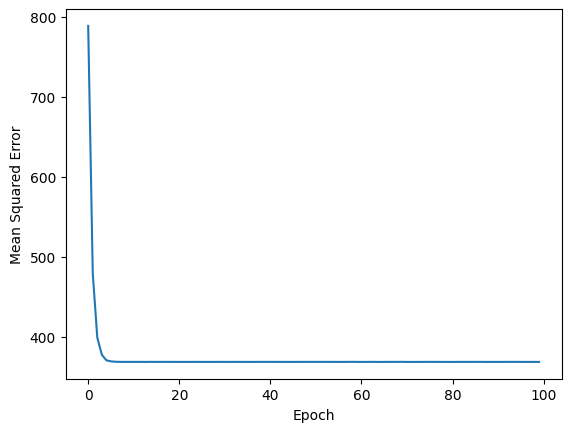

In [13]:
plt.plot(range(len(loss02)), loss02)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()